# Solving the SWE using NN + FNO

In [1]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


## Solve the SWE using NN

In [75]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t = mat_data['time_all'].flatten()

h_all.shape

dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])


(304, 100)

In [76]:
h_all.shape

(304, 100)

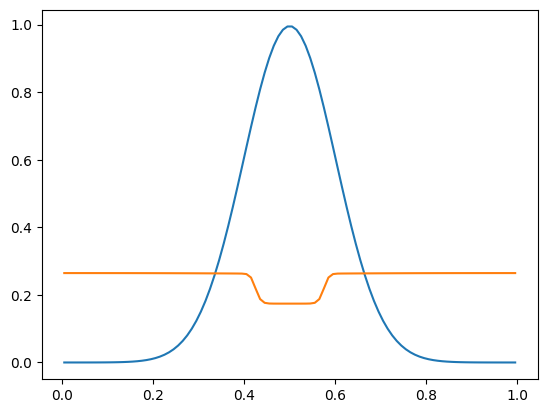

In [77]:
plt.plot(x, h_all[0])
plt.plot(x, h_all[-1])

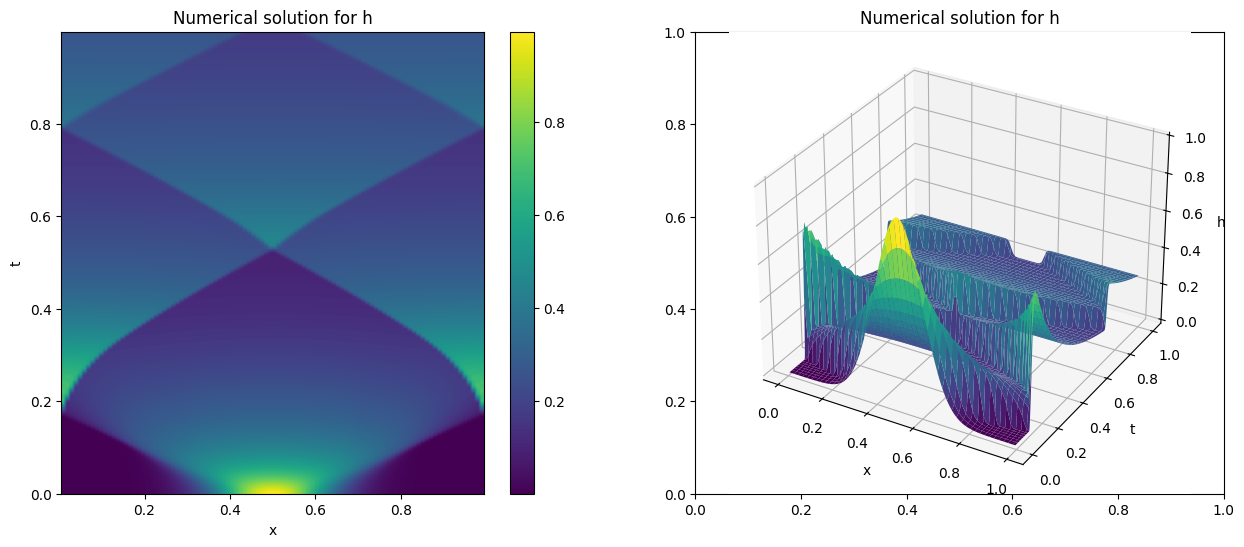

In [78]:
# Plot the data in x,t space
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
img = ax[0].imshow(h_all, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution for h')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('Numerical solution for h')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('h')
plt.show()


In [79]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * len(t))

h_train = h_all[:n_train, :]
h_test = h_all[n_train:, :]

# Split X and T into training and testing sets
X_train = X[:n_train, :]
X_test = X[n_train:, :]
T_train = T[:n_train, :]
T_test = T[n_train:, :]

### (i) FNN

In [82]:
h_all.shape[0]


(243, 100)


In [85]:
X, T = np.meshgrid(x, t)
print(X.shape)
print(T.shape)

(304, 100)
(304, 100)


In [86]:
# Define the RNN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1] + T.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(h_all.shape[1])) # Output layer
learning_rate = 0.01 # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack([X_train, T_train]), h_train, epochs=100, batch_size=16, validation_split=0.2)


Epoch 1/100


c:\Users\Matteo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0836 - val_loss: 0.0058
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0076
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0119
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - val_loss: 0.0072
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0086
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0110
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0127
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0170
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0269
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_l

In [88]:
# Evaluate the model on the test data
loss = model.evaluate(np.hstack([X_test, T_test]), h_test)
print(f'Test loss: {loss}')

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0853 
Test loss: 0.09326456487178802
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


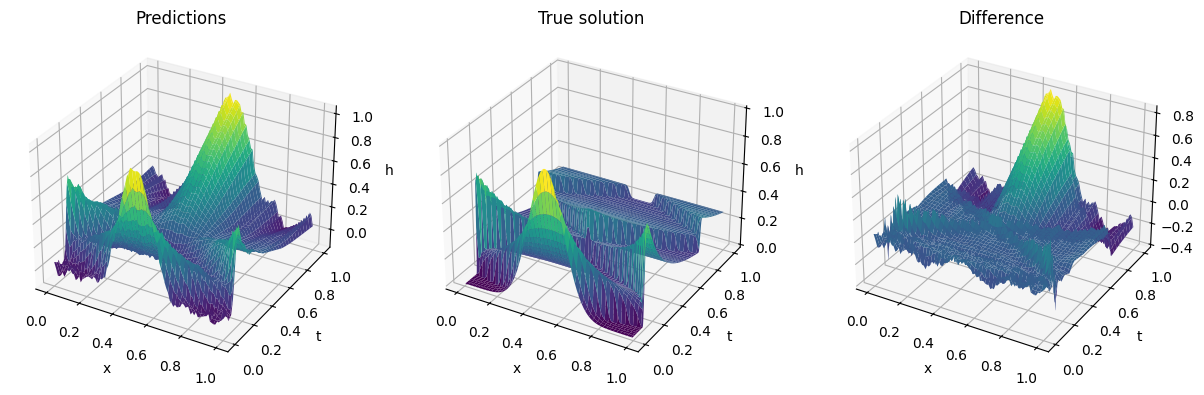

In [89]:
# Plot the predictions
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, T, predictions, cmap='viridis')
ax.set_title('Predictions')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, T, h_all, cmap='viridis')
ax.set_title('True solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, T, predictions - h_all, cmap='viridis')
ax.set_title('Difference')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

plt.show()


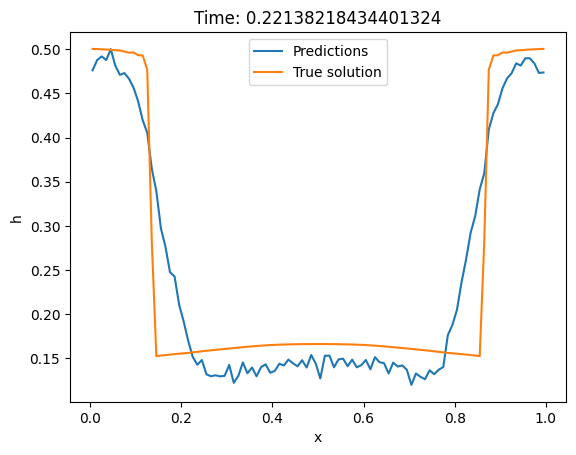

In [96]:
# Choose a random time index to plot
index = 100

# Plot the predictions
plt.plot(x, predictions[index], label='Predictions')
plt.plot(x, h_all[index], label='True solution')
plt.legend()
plt.title(f'Time: {t[index]}')
plt.xlabel('x')
plt.ylabel('h')
plt.show()



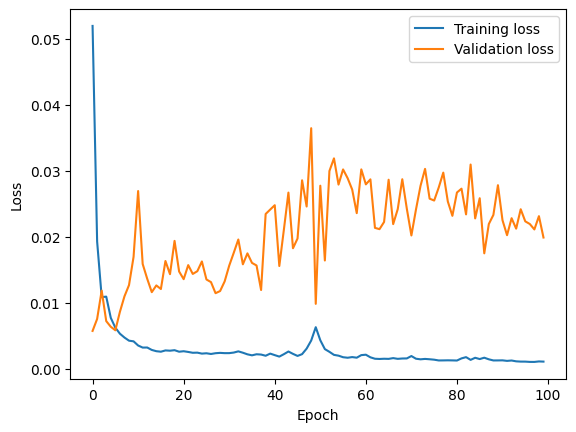

In [93]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

